# Self-Driving Car Engineer Nanodegree

## Deep Learning Project: Build a Traffic Sign Recognition Classifier

## Overview:

Imagine we are entering a drawing competition where the goal is to draw something amazing from scratch. Before the competition we train ourselves by looking at famous art, and observing the lines. To practice, we take a Monet, and then start to draw it ourselves, exclusively using arrows, trying to follow the lines. Then we compare our work to Monet's, with the goal that all our little arrows match his lines. Over time, the more we practice, the closer we can get out mental model to be like Monet's, and the better we will do in the art competition. This program is designed to do the process for us - to look at data, make some guesses of where the arrows should be, and create a model to use in the future.

To do this, we have one piece of paper we use as the answer key, and the other we write our guesses on. On our answer key, we have Monet's starry night. It's a beauty. So we go over to our guesses page and start drawing arrows wildly - at random almost! Then after a time we go back to our answer key and compare the two. We carefully add up the lengths of each arrow and compare. We erase some of the arrows on the guess paper and re-write them as we learn more. We group arrows together, starting with basic outlines and shapes, then filling in more complex features. Slowly, over time, we update our mental model for what each grouping of arrows should look like. Eventually we feel confident that, if given a fresh sheet of paper, by following our mental model of the groups of arrows, we could systematically make it look like the answer key. This mental knowledge we have gained is the machine's trained model. The arrows are vectors. Groups of arrows are matrices. In essence we are using the groups of arrows to detect patterns in the information.

This project has been quite interesting. This is a learning project, some code was provided by Udacity, some of the models are well known (ie LeNet, Dropout, etc.), and there a few functions from the forums. I have tried to be clear when there was obvious attribution. Enjoy! :)


---

# Step 1: Dataset exploration & pre-processing

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image.


In [1]:
# Load pickled data
import pickle

training_file = "train.p"
testing_file = "test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

print(y_train)
print(y_train.shape)

print("Complete")

[ 0  0  0 ..., 42 42 42]
(39209,)
Complete


In [2]:
import numpy as np

# Number of training examples
n_train = len(X_train)

# Number of testing examples.
n_test = len(X_test)

# What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# How many unique classes/labels there are in the dataset.
n_classes = max(y_train) + 1

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape is", image_shape)
print("Number of classes =", n_classes)
print(np.unique(y_train))
print("Complete")

Number of training examples = 39209
Number of testing examples = 12630
Image data shape is (32, 32, 3)
Number of classes = 43
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42]
Complete


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

35
Complete


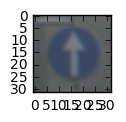

In [3]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

index = random.randint(1, len(X_train))
image = X_train[index].squeeze()

plt.figure(figsize=(1,1))
plt.imshow(image)
print(y_train[index])
print("Complete")

In [4]:
# TODO add convert to greyscale
# https://carnd-forums.udacity.com/questions/26216649/problem-when-converting-to-gray
def to_gray_scale(img_data):
    return cv2.cvtColor(img_data.astype(np.float32), cv2.COLOR_RGB2GRAY)

import cv2

X_train_gray = np.zeros([X_train.shape[0], X_train.shape[1], X_train.shape[2]])

for feature in range(len(X_train)):
    #print(X_train[feature].dtype)
    X_train_gray[feature] = to_gray_scale(X_train[feature])
    
X_train = X_train_gray


10
Complete


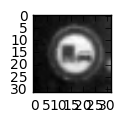

In [5]:
index = random.randint(1, len(X_train))
image = X_train[index].squeeze()

plt.figure(figsize=(1,1))
plt.imshow(image, cmap='gray')
print(y_train[index])
print("Complete")

In [6]:
# Credit for this function to:
# https://carnd-forums.udacity.com/questions/10322627/project-2-unbalanced-data-generating-additional-data-by-jittering-the-original-image

# After my own research shown here:
# https://carnd-forums.udacity.com/questions/36049206/how-to-scale-zoom-images-p2-traffic-sign

import cv2

def transform_image(img,ang_range,shear_range,trans_range):
    '''
    This function transforms images to generate new images.
    The function takes in following arguments,
    1- Image
    2- ang_range: Range of angles for rotation
    3- shear_range: Range of values to apply affine transform to
    4- trans_range: Range of values to apply translations over. 
    
    A Random uniform distribution is used to generate different parameters for transformation
    
    '''
    # Rotation
    ang_rot = np.random.uniform(ang_range)-ang_range/2
    # updated to reflect gray pipeline
    rows,cols = img.shape    
    Rot_M = cv2.getRotationMatrix2D((cols/2,rows/2),ang_rot,1)

    # Translation
    tr_x = trans_range*np.random.uniform()-trans_range/2
    tr_y = trans_range*np.random.uniform()-trans_range/2
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])

    # Shear
    pts1 = np.float32([[5,5],[20,5],[5,20]])

    pt1 = 5+shear_range*np.random.uniform()-shear_range/2
    pt2 = 20+shear_range*np.random.uniform()-shear_range/2

    pts2 = np.float32([[pt1,5],[pt2,pt1],[5,pt2]])

    shear_M = cv2.getAffineTransform(pts1,pts2)
        
    img = cv2.warpAffine(img,Rot_M,(cols,rows))
    img = cv2.warpAffine(img,Trans_M,(cols,rows))
    img = cv2.warpAffine(img,shear_M,(cols,rows))
    
    return img

## Transformation testing

Original:


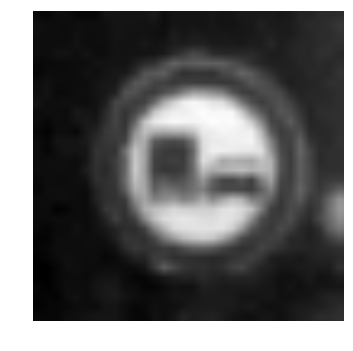

Generated images:


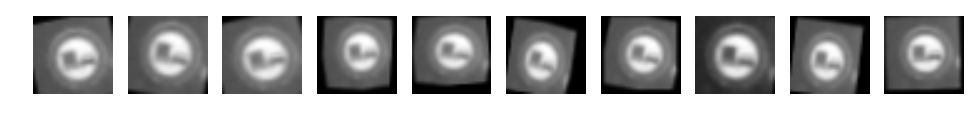

In [7]:
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg

print("Original:")
plt.imshow(image, cmap="gray");
plt.axis('off');
plt.show()

gs1 = gridspec.GridSpec(10, 10)
gs1.update(wspace=0.01, hspace=0.02)
plt.figure(figsize=(12,12))

print("Generated images:")
for i in range(10):
    ax1 = plt.subplot(gs1[i])
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_aspect('equal')
    img = transform_image(image,30,4,4)

    plt.subplot(10,10,i+1)
    plt.imshow(img, cmap="gray")
    plt.axis('off')

plt.show()

-----
## Image Generation

Generating additional features.
Bins [ 210 2220 2250 1410 1980 1860  420 1440 1410 1470 2010 1320 2100 2160  780
  630  420 1110 1200  210  360  330  390  510  270 1500  600  240  540  270
  450  780  240  689  420 1200  390  210 2070  300  360  240  240]
39209
Current label name:  Speed limit (20km/h)
Current label id:  0
Number of features:  210
features_to_be_generated:  0
Passing, no images to generate


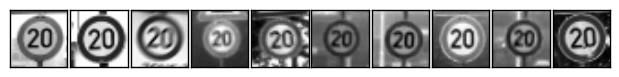

-----------------------------------------------------

Current label name:  Speed limit (30km/h)
Current label id:  1
Number of features:  2220
features_to_be_generated:  0
Passing, no images to generate


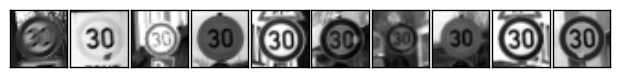

-----------------------------------------------------

Current label name:  Speed limit (50km/h)
Current label id:  2
Number of features:  2250
features_to_be_generated:  0
Passing, no images to generate


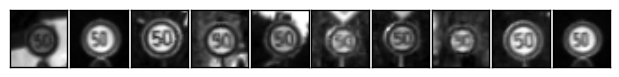

-----------------------------------------------------

Current label name:  Speed limit (60km/h)
Current label id:  3
Number of features:  1410
features_to_be_generated:  0
Passing, no images to generate


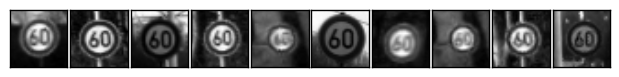

-----------------------------------------------------

Current label name:  Speed limit (70km/h)
Current label id:  4
Number of features:  1980
features_to_be_generated:  0
Passing, no images to generate


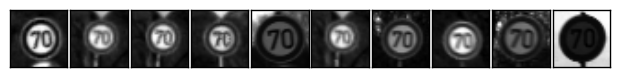

-----------------------------------------------------

Current label name:  Speed limit (80km/h)
Current label id:  5
Number of features:  1860
features_to_be_generated:  0
Passing, no images to generate


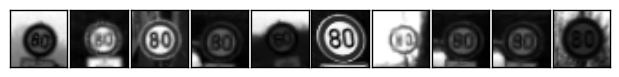

-----------------------------------------------------

Current label name:  End of speed limit (80km/h)
Current label id:  6
Number of features:  420
features_to_be_generated:  0
Passing, no images to generate


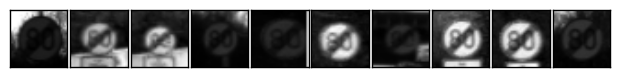

-----------------------------------------------------

Current label name:  Speed limit (100km/h)
Current label id:  7
Number of features:  1440
features_to_be_generated:  0
Passing, no images to generate


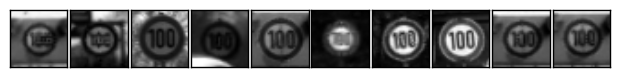

-----------------------------------------------------

Current label name:  Speed limit (120km/h)
Current label id:  8
Number of features:  1410
features_to_be_generated:  0
Passing, no images to generate


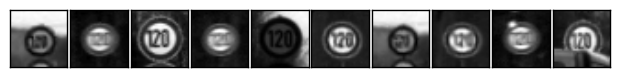

-----------------------------------------------------

Current label name:  No passing
Current label id:  9
Number of features:  1470
features_to_be_generated:  0
Passing, no images to generate


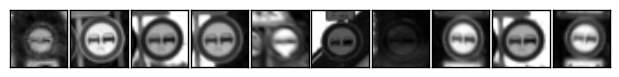

-----------------------------------------------------

Current label name:  No passing for vehicles over 3.5 metric tons
Current label id:  10
Number of features:  2010
features_to_be_generated:  0
Passing, no images to generate


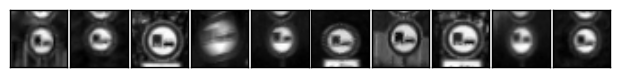

-----------------------------------------------------

Current label name:  Right-of-way at the next intersection
Current label id:  11
Number of features:  1320
features_to_be_generated:  0
Passing, no images to generate


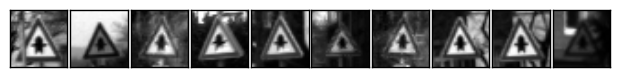

-----------------------------------------------------

Current label name:  Priority road
Current label id:  12
Number of features:  2100
features_to_be_generated:  0
Passing, no images to generate


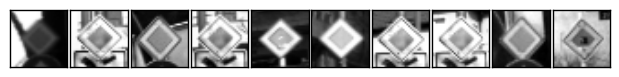

-----------------------------------------------------

Current label name:  Yield
Current label id:  13
Number of features:  2160
features_to_be_generated:  0
Passing, no images to generate


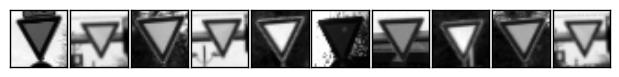

-----------------------------------------------------

Current label name:  Stop
Current label id:  14
Number of features:  780
features_to_be_generated:  0
Passing, no images to generate


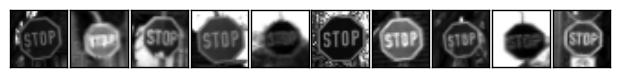

-----------------------------------------------------

Current label name:  No vehicles
Current label id:  15
Number of features:  630
features_to_be_generated:  0
Passing, no images to generate


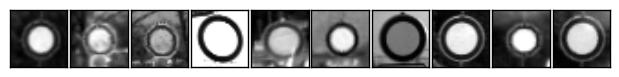

-----------------------------------------------------

Current label name:  Vehicles over 3.5 metric tons prohibited
Current label id:  16
Number of features:  420
features_to_be_generated:  0
Passing, no images to generate


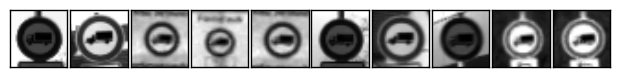

-----------------------------------------------------

Current label name:  No entry
Current label id:  17
Number of features:  1110
features_to_be_generated:  0
Passing, no images to generate


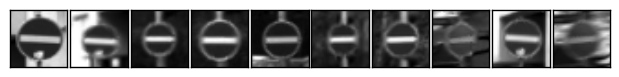

-----------------------------------------------------

Current label name:  General caution
Current label id:  18
Number of features:  1200
features_to_be_generated:  0
Passing, no images to generate


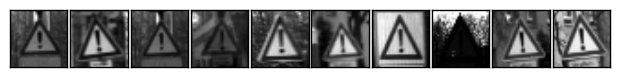

-----------------------------------------------------

Current label name:  Dangerous curve to the left
Current label id:  19
Number of features:  210
features_to_be_generated:  0
Passing, no images to generate


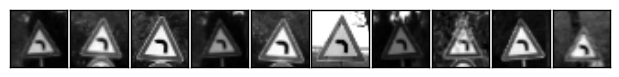

-----------------------------------------------------

Current label name:  Dangerous curve to the right
Current label id:  20
Number of features:  360
features_to_be_generated:  0
Passing, no images to generate


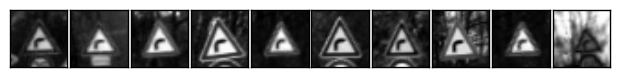

-----------------------------------------------------

Current label name:  Double curve
Current label id:  21
Number of features:  330
features_to_be_generated:  0
Passing, no images to generate


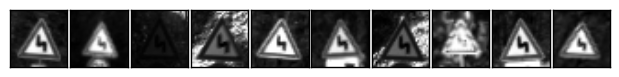

-----------------------------------------------------

Current label name:  Bumpy road
Current label id:  22
Number of features:  390
features_to_be_generated:  0
Passing, no images to generate


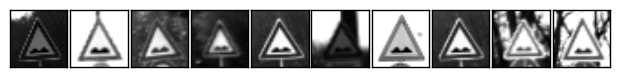

-----------------------------------------------------

Current label name:  Slippery road
Current label id:  23
Number of features:  510
features_to_be_generated:  0
Passing, no images to generate


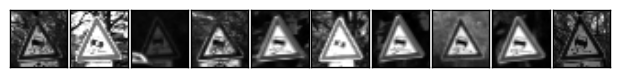

-----------------------------------------------------

Current label name:  Road narrows on the right
Current label id:  24
Number of features:  270
features_to_be_generated:  0
Passing, no images to generate


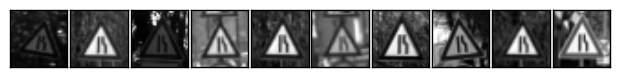

-----------------------------------------------------

Current label name:  Road work
Current label id:  25
Number of features:  1500
features_to_be_generated:  0
Passing, no images to generate


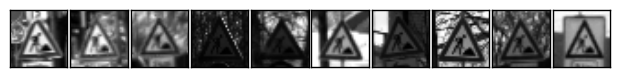

-----------------------------------------------------

Current label name:  Traffic signals
Current label id:  26
Number of features:  600
features_to_be_generated:  0
Passing, no images to generate


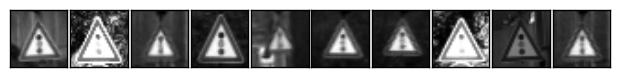

-----------------------------------------------------

Current label name:  Pedestrians
Current label id:  27
Number of features:  240
features_to_be_generated:  0
Passing, no images to generate


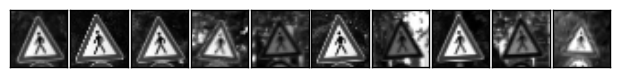

-----------------------------------------------------

Current label name:  Children crossing
Current label id:  28
Number of features:  540
features_to_be_generated:  0
Passing, no images to generate


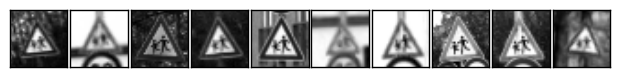

-----------------------------------------------------

Current label name:  Bicycles crossing
Current label id:  29
Number of features:  270
features_to_be_generated:  0
Passing, no images to generate


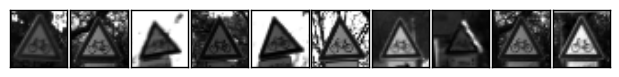

-----------------------------------------------------

Current label name:  Beware of ice/snow
Current label id:  30
Number of features:  450
features_to_be_generated:  0
Passing, no images to generate


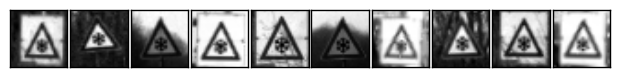

-----------------------------------------------------

Current label name:  Wild animals crossing
Current label id:  31
Number of features:  780
features_to_be_generated:  0
Passing, no images to generate


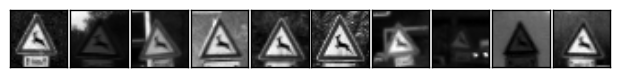

-----------------------------------------------------

Current label name:  End of all speed and passing limits
Current label id:  32
Number of features:  240
features_to_be_generated:  0
Passing, no images to generate


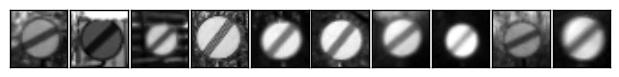

-----------------------------------------------------

Current label name:  Turn right ahead
Current label id:  33
Number of features:  689
features_to_be_generated:  0
Passing, no images to generate


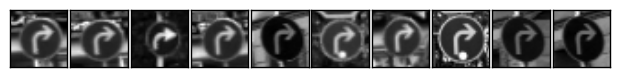

-----------------------------------------------------

Current label name:  Turn left ahead
Current label id:  34
Number of features:  420
features_to_be_generated:  0
Passing, no images to generate


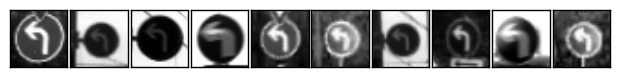

-----------------------------------------------------

Current label name:  Ahead only
Current label id:  35
Number of features:  1200
features_to_be_generated:  0
Passing, no images to generate


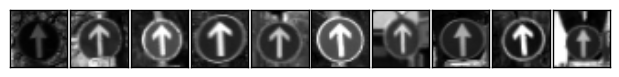

-----------------------------------------------------

Current label name:  Go straight or right
Current label id:  36
Number of features:  390
features_to_be_generated:  0
Passing, no images to generate


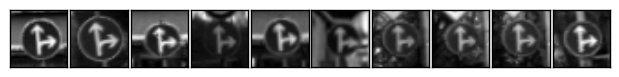

-----------------------------------------------------

Current label name:  Go straight or left
Current label id:  37
Number of features:  210
features_to_be_generated:  0
Passing, no images to generate


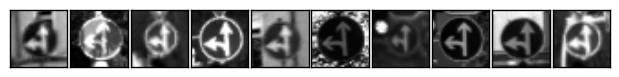

-----------------------------------------------------

Current label name:  Keep right
Current label id:  38
Number of features:  2070
features_to_be_generated:  0
Passing, no images to generate


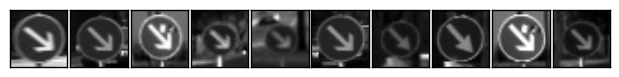

-----------------------------------------------------

Current label name:  Keep left
Current label id:  39
Number of features:  300
features_to_be_generated:  0
Passing, no images to generate


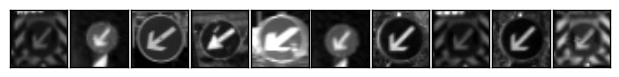

-----------------------------------------------------

Current label name:  Roundabout mandatory
Current label id:  40
Number of features:  360
features_to_be_generated:  0
Passing, no images to generate


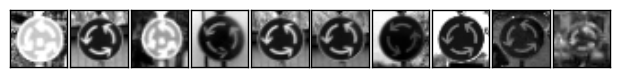

-----------------------------------------------------

Current label name:  End of no passing
Current label id:  41
Number of features:  240
features_to_be_generated:  0
Passing, no images to generate


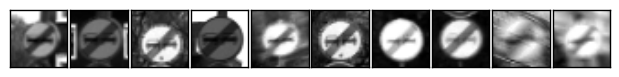

-----------------------------------------------------

Current label name:  End of no passing by vehicles over 3.5 metric tons
Current label id:  42
Number of features:  240
features_to_be_generated:  0
Passing, no images to generate


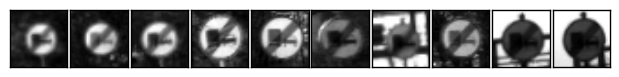

-----------------------------------------------------

Bins [ 210 2220 2250 1410 1980 1860  420 1440 1410 1470 2010 1320 2100 2160  780
  630  420 1110 1200  210  360  330  390  510  270 1500  600  240  540  270
  450  780  240  689  420 1200  390  210 2070  300  360  240  240]
Complete


In [8]:
"""

This loop looks at each label in the data set and generates images up to the feature_count_goal
specified above.

"""

goal_number_of_features = 5000   # features per label
ang_range = 15   # Range of angles for rotation
shear_range = 2   # Range of values to apply affine transform to
trans_range = 2   # Range of values to apply translations over.

print("Generating additional features.")
print("Bins", np.bincount(y_train))

from pandas.io.parsers import read_csv
signnames = read_csv("signnames.csv").values[:, 1]
unique_labels = np.unique(y_train)

print(len(X_train))
    
for label_id in range(len(unique_labels)):
    
    unique_labels = np.unique(y_train)
    #Print update to feature tracking.
    print("Current label name: ", signnames[label_id])
    print("Current label id: ", label_id)
    
    #Print feature currently being generate    
    y_labels = np.where(y_train == label_id)
    
    number_of_features = len(X_train[y_labels])
    print("Number of features: ", number_of_features)
    feature_difference = goal_number_of_features - number_of_features
    
    # Set features to generate to 0 if less than 0
    if feature_difference > 0:
        features_to_be_generated = feature_difference
    else:
        features_to_be_generated = 0
    print("features_to_be_generated: ", features_to_be_generated)
    
    # Graceful handling if no features to be generated
    if features_to_be_generated > 0:
        
        print("Generating images for ", signnames[label_id])
        new_features = []
        new_labels = []
        
        # Start actually generated features while there are features to be generated
        while i <= features_to_be_generated:
            for feature in X_train[y_labels]:
                
                # Graceful stopping if > 1 passes through loop
                if features_to_be_generated == 0: 
                    break
                
                else:
                    # generate image
                    new_image = transform_image(feature,ang_range,shear_range,trans_range)
                    
                    new_features.append(new_image)
                    new_labels.append(label_id)
                    
                    features_to_be_generated = features_to_be_generated - 1
        i = i + 1

        # Append image to data
        # IMPORTANT axis=0 must be set or strange issues even though supposedly default is axis=0
        
        X_train = np.append(X_train, new_features, axis=0)
        y_train = np.append(y_train, new_labels, axis=0)
        
    else:
        print("Passing, no images to generate")
        
    # update y labels
    y_labels = np.where(y_train == label_id)
    x = np.array(y_labels)
    x_min = x[0, -200]
    x_max = x[0, -1]
    random_index = random.sample(range(x_min, x_max), 10)
    
    # graphing function concepts from http://navoshta.com/traffic-signs-classification/
    fig = plt.figure(figsize = (6, 1))
    fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.05)
    
    for i in range(10):
        axis = fig.add_subplot(1, 10, i + 1, xticks=[], yticks=[])
        axis.imshow(X_train[random_index[i]], cmap="gray")
    plt.show()
    print("-----------------------------------------------------\n")


bins = np.bincount(y_train)
    
print("Bins", bins)
print("Complete")

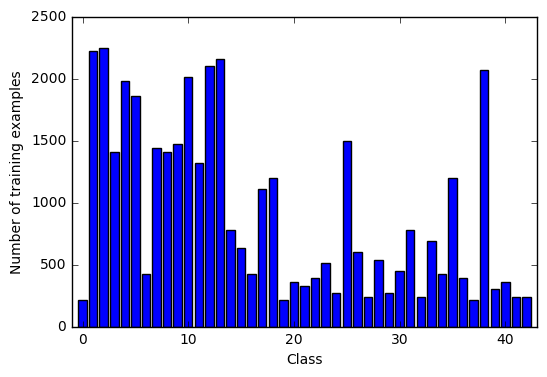

In [33]:
# graphing function concepts from http://navoshta.com/traffic-signs-classification/
plt.bar( np.arange( 43 ), bins, align='center' )
plt.xlabel('Class')
plt.ylabel('Number of training examples')
plt.xlim([-1, 43])
plt.show()

In [34]:
   
# Normalize features
print('Scale features to be in 0 to 1')
X_train = (X_train / 255.).astype(np.float32)

inputs_per_class = np.bincount(y_train)
print(inputs_per_class)
n_train = len(X_train)

print("Number of training examples =", n_train)
# store data in a pickle file ?

Scale features to be in 0 to 1
[ 168 1776 1800 1128 1584 1488  336 1152 1128 1176 1608 1056 1680 1728  624
  504  336  888  960  168  288  264  312  408  216 1200  480  192  432  216
  360  624  192  551  336  960  312  168 1656  240  288  192  192]
Number of training examples = 31367


In [35]:
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train)
print("Complete")

Complete


## Validation set creation

In [12]:
# split into 80% for train and 20% for validation

seed = 54645
from sklearn.cross_validation import train_test_split
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.20, random_state=seed, stratify=y_train)

n_train = len(X_train)
print("Number of training examples =", n_train)

n_validation = len(X_validation)
print("Number of validation examples =", n_validation)
print("Complete")

Number of training examples = 31367
Number of validation examples = 7842
Complete


### Question 1  and  Question 2

_Describe how you preprocessed the data. Why did you choose that technique?_

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer for 1 and 2:**

From reading LeCun's paper on traffic sign recongition he suggested generating additional data, ie by rotating, scaling, and shifting data. I then researched options to do so.

From reading various blog posts I learnt about "binning" data, and have attempted to balance the data set. Finnally there is a feature normalization.

I had been used to using a cross validation set to test the network's performance prior to using the real test data. I researched ways to implmenet a validation set.


Please In Question 2 describe in more details how many data you used for the training, validation and testing, also describe how you got it.


I used 2000 images per label (x total), I splite the data as described here:



Number of training examples = 77400

Number of validation examples = 51600

Original number of training examples = 39209

Number of testing examples = 12630

.


----

# Step 2: Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

In [13]:
# settings

EPOCHS = 160
BATCH_SIZE = 256
LEARNING_RATE = 0.0001



In [14]:
import tensorflow as tf
from tensorflow.contrib.layers import flatten

def LeNet(x, keep_prob):    
    # Hyperparameters
    mu = 0
    sigma = 0.1
    
    # gray scale fix
    # https://carnd-forums.udacity.com/questions/18449441/p2-valueerror-cannot-feed-value-of-shape-512-32-32-for-tensor-placeholder580-which-has-shape-32-32-1
    image = tf.reshape(x, [-1,32,32,1])

    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    convolutional_1_weights = tf.Variable(tf.truncated_normal(shape=(5,5,1,6), mean = mu, stddev = sigma))
    convolutional_1_bias = tf.Variable(tf.zeros(6)) # set to 6 as output is 6
    convolutional_1 = tf.nn.conv2d(image, convolutional_1_weights, strides=[1,1,1,1], padding='VALID') + convolutional_1_bias
    
    # Activation.
    convolutional_1 = tf.nn.relu(convolutional_1)

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    # Stride of 2 reduces output by 2
    convolutional_1 = tf.nn.max_pool(convolutional_1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')
    ## END Layer 1
    
    
    # Layer 2: Convolutional. Output = 10x10x16.
    convolutional_2_weights = tf.Variable(tf.truncated_normal(shape=(5,5,6,16), mean = mu, stddev = sigma))
    convolutional_2_bias = tf.Variable(tf.zeros(16))
    # pass the first layer
    convolutional_2 = tf.nn.conv2d(convolutional_1, convolutional_2_weights, strides=[1,1,1,1], padding='VALID' ) + convolutional_2_bias
    
    # Activation.
    convolutional_2 = tf.nn.relu(convolutional_2)
    
    # Pooling. Input = 10x10x16. Output = 5x5x16.
    convolutional_2 = tf.nn.max_pool(convolutional_2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')
    
    # Flatten. Input = 5x5x16. Output = 400.
    fully_connected_0 = flatten(convolutional_2)
    ### End Layer 2
    
    
    # Layer 3: Fully Connected. Input = 400. Output = 160.
    fully_connected_1_weights = tf.Variable(tf.truncated_normal(shape=(400,160), mean=mu, stddev=sigma))
    fully_connected_1_bias = tf.Variable(tf.zeros(160))
    fully_connected_1 = tf.matmul(fully_connected_0, fully_connected_1_weights) + fully_connected_1_bias
    
    # Activation.
    fully_connected_1 = tf.nn.relu(fully_connected_1)
    
    # Layer 4: Fully Connected. Input = 160. Output = 84.
    # shape = (input, output)
    fully_connected_2_weights = tf.Variable(tf.truncated_normal(shape=(160,84), mean=mu, stddev=sigma))
    fully_connected_2_bias = tf.Variable(tf.zeros(84))
    fully_connected_2 = tf.matmul(fully_connected_1, fully_connected_2_weights) + fully_connected_2_bias
    
    # Activation.
    fully_connected_2 = tf.nn.relu(fully_connected_2)
    
    # drop out
    """
    
    """
    drop_out = tf.nn.dropout(fully_connected_2, keep_prob)
    
    
    # Layer 5: Fully Connected. Input = 84. Output = 43.
    fully_connected_3_weights = tf.Variable(tf.truncated_normal(shape=(84,43), mean=mu, stddev=sigma))
    fully_connected_3_bias = tf.Variable(tf.zeros(43))
    logits = tf.matmul(drop_out, fully_connected_3_weights) + fully_connected_3_bias
        
    return logits

print("Complete")

Complete


### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

I primarily used the LetNet Architecture. The the main exception is I also added in drop_out as implemented by TensorFlow.

The input to the model is the 32x32 images.

The filter size in case of a convolutional neural network. What is it?
Output = 10x10x16.


The padding used in the convolutional layer. What type of padding was used? Why did you make this choice, and how did it affect your architecture?



The details of the max pooling - what where the sizes of the strides?
strides=[1,2,2,1]


The flattening of the model from 4D to 2D, how does this flattening occur?
tf.nn.conv2d









In [15]:
### Train your model here.

x = tf.placeholder(tf.float32, (None, 32, 32))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)

# added this to fix bug CUDA_ERROR_ILLEGAL_ADDRESS / kernal crash
with tf.device('/cpu:0'):
    one_hot_y = tf.one_hot(y, 43)

logits = LeNet(x, keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = LEARNING_RATE)
training_operation = optimizer.minimize(loss_operation)

print("Complete")

Complete


In [16]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

print("Complete")

Complete


## Training

In [17]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: .5})
            
        validation_accuracy = evaluate(X_validation, y_validation)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, '.\lenet')
    print("Model saved")
    
print("Complete")

Training...

EPOCH 1 ...
Validation Accuracy = 0.197

EPOCH 2 ...
Validation Accuracy = 0.438

EPOCH 3 ...
Validation Accuracy = 0.539

EPOCH 4 ...
Validation Accuracy = 0.658

EPOCH 5 ...
Validation Accuracy = 0.724

EPOCH 6 ...
Validation Accuracy = 0.771

EPOCH 7 ...
Validation Accuracy = 0.802

EPOCH 8 ...
Validation Accuracy = 0.825

EPOCH 9 ...
Validation Accuracy = 0.840

EPOCH 10 ...
Validation Accuracy = 0.858

Model saved
Complete


## Evaluation

In [18]:
# pre processing
# TODO abstract this better...

X_test_gray = np.zeros([X_test.shape[0], X_test.shape[1], X_test.shape[2]])

for feature in range(len(X_test)):
    #print(X_train[feature].dtype)
    X_test_gray[feature] = to_gray_scale(X_test[feature])
    
X_test = X_test_gray

X_test = (X_test / 255.).astype(np.float32)

In [19]:
#Test data

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.794


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

I used the AdamOptimizer from pervious lesson as I don't understand well enough to use anything else. 
For batch size I find small batches seem to work better. For epochs I looked at results till it stopped learning. For learning rate I tested slower rates till it hit where I wanted. Dropout is set to 50% as recommended by Mr. Hinton's paper. I think that's about it! One Hot is set at 43 as there are 43 classes.

Please add the batch size, and the epochs used.

EPOCHS = 100

BATCH_SIZE = 64

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

Generally I started with LeNet, added dropout, added validation set, added binning comboed with jittery functions / gernating extra data. At each step I generally tested to at least 20 EPOCHs to see results, and mapped out results.

Beyond the apparently decent accuracy results, I don't know if it's suitable or not becuase I don't know any other common models. I don't feel I understand it well enough yet.


Did you only try a Convolutional Neural Network? What about a fully connected network? Did you try this too? If yes/no, then why?

What led you to choose 2 convolutional layers and 3 fully connected layers? 

Is it that you got inspired by some particular research papers? Or some publicly available models (maybe tensorflow examples) to guide your decision making of the architecture?

Any particular attribute of the dataset led you to use make particular model design choices?

Any other particular model architecture you tried? If yes, then how did they perform?



---

# Step 3: Test on new input


### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

Please make a discussion about the qualities of the traffic signs in the images, and described whether they would be difficult for the model to classify. I suggest you to write here if the images chosen from the internet are contained in the data set.

Please write your answer in the section presented in the screenshot below.





In [20]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

from scipy.misc import imresize
new_label_sign_ids = read_csv("new_labels.csv").values[:, 0]
print(new_label_sign_ids)

imgs = ['1.jpg', '2.jpg', '3.jpg', '4.jpg', '5.jpg']
new_input = []

for imgname in imgs:
    image = mpimg.imread('extra-images/' + imgname)
    image = imresize(image, (32,32))
    new_input.append(image)

[14 17 11 11 25]


### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset?

**Answer:**

I am happy to see working like that! Please provide the percentage of accuracy of your model in the images downloaded from the internet, and compare it with the accuracy of the network on the testing and validation set to complete this section.

Again, I couldn't see a reply to this section. Make sure that you both quantitatively and qualitatively compare the results of testing on the test dataset to those of testing the model on the newly captured images in your next submission.



## New input evaulation

(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(1,)
(2,)
(3,)
(4,)
(5,)
[14, 17, 11, 11, 25]


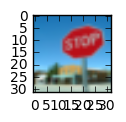

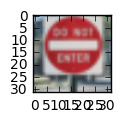

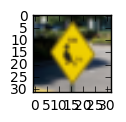

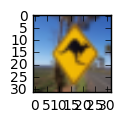

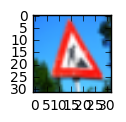

Number of training examples = 5
Number of labels = 5


In [21]:
# Combine images into pickle data format

imagesTogether = []
new_labels = []

for image in new_input:
    image = cv2.resize(image, (32, 32))
    print(image.shape)
    
    imagesTogether.append(image) 
    #print(len(imagesTogether))
    
    imagesTogetherNP=np.asarray(imagesTogether)
    #print(imagesTogetherNP.shape)
    
for i in new_label_sign_ids:
    
    new_labels.append(i)
    #print(len(new_labels))
    
    new_labelsNP=np.asarray(new_labels)
    print(new_labelsNP.shape)

print(new_labels)

for image in imagesTogetherNP:
    plt.figure(figsize=(1,1))
    plt.imshow(image)
    plt.show()

print("Number of training examples =", len(imagesTogetherNP))
print("Number of labels =", len(new_labels))


In [22]:
X_input_gray = np.zeros([imagesTogetherNP.shape[0], imagesTogetherNP.shape[1], imagesTogetherNP.shape[2]])

for feature in range(len(imagesTogetherNP)):
    #print(X_train[feature].dtype)
    X_input_gray[feature] = to_gray_scale(imagesTogetherNP[feature])
    
imagesTogetherNP = X_input_gray


In [23]:

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    test_accuracy = evaluate(imagesTogetherNP, new_labels)
    print("Test Accuracy = {:.3f}".format(test_accuracy))
    
    

Test Accuracy = 0.000


### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:**

Please after visualizing the softmax probabilities of the predictions on the captured images, for each image explain the certainty of its predictions. This has much to do with the top 5 softmax probabilities of the predictions of the model on the captured images. Is the top one very high compared the the last 4? Or is the distribution more even?




In [28]:

new_input_32 = np.float32(imagesTogetherNP)

#print(X_test.dtype)
#print(imagesTogetherNP.dtype)
#print(new_input_32.dtype)

predictSoftmax = tf.nn.softmax(logits)

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    print("Model restored")
    
    softmaxProb  = sess.run(predictSoftmax, feed_dict={x: new_input_32, keep_prob: 1.0})
         
    top5 = sess.run(tf.nn.top_k(tf.constant(softmaxProb), k=5, sorted=True))
    
    print(top5)


Model restored
TopKV2(values=array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00],
       [  1.00000000e+00,   1.73189908e-35,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00],
       [  9.99999881e-01,   1.30559002e-07,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00],
       [  1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00],
       [  1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00]], dtype=float32), indices=array([[18,  0,  1,  2,  3],
       [13, 35,  0,  1,  2],
       [12,  2,  0,  1,  3],
       [ 4,  0,  1,  2,  3],
       [31,  0,  1,  2,  3]]))


Actual class:   Stop 


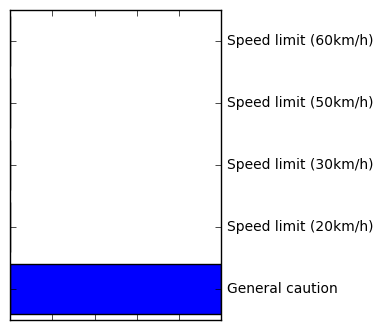

----------------------------------------------------------

Actual class:   No entry


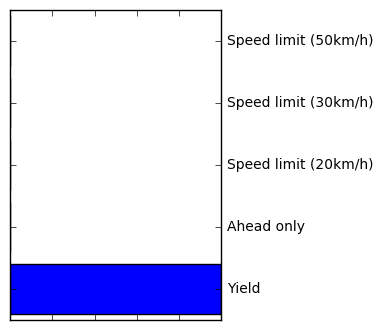

----------------------------------------------------------

Actual class:   ducks


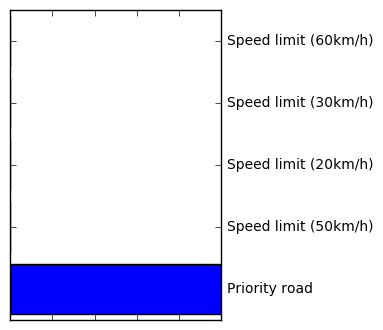

----------------------------------------------------------

Actual class:   kangeroos


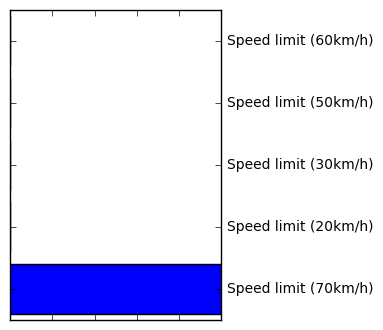

----------------------------------------------------------

Actual class:   Road work


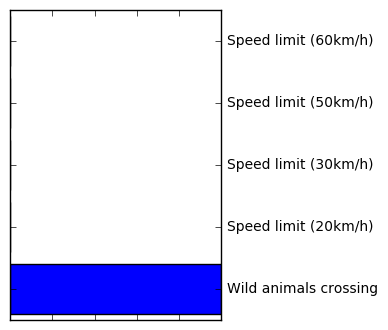

----------------------------------------------------------



In [30]:
new_label_sign_names = read_csv("new_labels.csv").values[:, 1]


# Credit https://github.com/navoshta/traffic-signs/blob/master/Traffic_Signs_Recognition.ipynb
def plot_image_statistics(predictions, index):
    plt.subplot2grid((2, 2), (0, 1), colspan=1, rowspan=2)
    plt.barh(np.arange(5)+.5, predictions[0][index], align='center')
    plt.yticks(np.arange(5)+.5, signnames[predictions[1][index].astype(int)])
    plt.tick_params(axis='both', which='both', labelleft='off', labelright='on', labeltop='off', labelbottom='off')
    plt.show()
    
    
for i in range(5):
    print("Actual class: ", new_label_sign_names[i])
    plot_image_statistics(top5, i)
    print("----------------------------------------------------------\n")
    

-----
## Reflections